<a href="https://colab.research.google.com/github/hugol1212/Fundamentos/blob/main/practica3_1_alumnos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Polynomial curve fitting

In [ ]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [ ]:
#Estos son los datos, esto es lo que voy a tener que cambiar en el examen

# Generar datos sinusoidales
np.random.seed(42)
#Generamos 100 observaciones
n_points = 100
#X es un vector de valores entre 0 y 1
x = np.linspace(0, 1, n_points)
#Creamos un seno de amplitud 1 y frecuencia 4pi
y_true = np.sin(4 * np.pi * x)
#Creammos el ruido
noise = np.random.normal(0, 0.1, n_points)
#Añadimos ruido al seno
y = y_true + noise

# Grado del polinomio
degree = 5

In [ ]:
## 1. Generar matriz de Vandermonde

## 2. Implementación de la matriz Φ (Chebyshev)

## 3. Implementación de la matriz Φ (Legendre)

In [ ]:
def chebyshev_design_matrix(x, degree):
    """
    Construye la matriz de diseño usando polinomios de Chebyshev (T_k).

    Parámetros
    ----------
    x : array (N,)
        Datos de entrada en [-1, 1]
    degree : int
        Grado máximo

    Retorna
    -------
    Phi : array (N, degree+1)
        Matriz de diseño
    """
    x = np.asarray(x)
    N = len(x)
    Phi = np.zeros((N, degree + 1))

    # T_0(x) = 1
    Phi[:, 0] = 1.0

    if degree >= 1:
        # T_1(x) = x
        Phi[:, 1] = x

    # Recurrencia: T_{k+1}(x) = 2x T_k(x) - T_{k-1}(x)
    for k in range(1, degree):
        Phi[:, k + 1] = 2 * x * Phi[:, k] - Phi[:, k - 1]

    return Phi


In [ ]:
def legendre_design_matrix(x, degree):
    """
    Construye la matriz de diseño usando polinomios de Legendre.

    Parámetros
    ----------
    x : array (N,)
        Datos de entrada en [-1, 1]
    degree : int
        Grado máximo del polinomio

    Retorna
    -------
    Phi : array (N, degree+1)
        Matriz de diseño
    """
    x = np.asarray(x)
    N = len(x)
    Phi = np.zeros((N, degree + 1))

    # P_0(x) = 1
    Phi[:, 0] = 1.0

    if degree >= 1:
        # P_1(x) = x
        Phi[:, 1] = x

    # Recurrencia:
    # (k+1) P_{k+1}(x) = (2k+1) x P_k(x) - k P_{k-1}(x)
    for k in range(1, degree):
        Phi[:, k + 1] = ((2*k + 1) * x * Phi[:, k] - k * Phi[:, k - 1]) / (k + 1)

    return Phi


In [ ]:
import cvxpy as cp
import numpy as np

A = np.vander(x, degree + 1, increasing=True)

beta_cvx = cp.Variable(degree + 1)
objective = cp.Minimize(cp.sum_squares(A @ beta_cvx - y))
problem = cp.Problem(objective)
problem.solve()

coeff_cvx = beta_cvx.value

#Calculamos los valores de w*
print("Optimal objective value:", problem.value)
print("w_cvx:", coeff_cvx)


Optimal objective value: 5.8446624206372695
w_cvx: [-4.71138796e-01  4.21080221e+01 -3.45718981e+02  9.71940993e+02
 -1.11351690e+03  4.46184837e+02]


In [ ]:
# 2. Solución cerrada
#Esta es otra forma de hallarlos
coeff_closed = np.linalg.inv(A.T@A)@A.T@y
print(coeff_closed)

[-4.71138799e-01  4.21080221e+01 -3.45718982e+02  9.71940994e+02
 -1.11351690e+03  4.46184837e+02]


In [ ]:
# 3. Usando numpy.polyfit
coeff_numpy =np.polyfit(x, y, degree)[::-1] #Revertir el orden para comparación


# Comparar los resultados
print("Coeficientes obtenidos:")
print(f"CVXPY:       {coeff_cvx}")
print(f"Sol. Cerrada: {coeff_closed}")
print(f"Numpy:       {coeff_numpy}")

Coeficientes obtenidos:
CVXPY:       [-4.71138796e-01  4.21080221e+01 -3.45718981e+02  9.71940993e+02
 -1.11351690e+03  4.46184837e+02]
Sol. Cerrada: [-4.71138799e-01  4.21080221e+01 -3.45718982e+02  9.71940994e+02
 -1.11351690e+03  4.46184837e+02]
Numpy:       [-4.71138800e-01  4.21080221e+01 -3.45718982e+02  9.71940994e+02
 -1.11351690e+03  4.46184837e+02]


In [ ]:
# Representar los resultados
x_fit = np.linspace(0, 1, 100)
y_fit_cvx = np.polyval(coeff_cvx[::-1], x_fit)
y_fit_closed = np.polyval(coeff_closed[::-1], x_fit)
y_fit_numpy = np.polyval(coeff_numpy[::-1], x_fit)

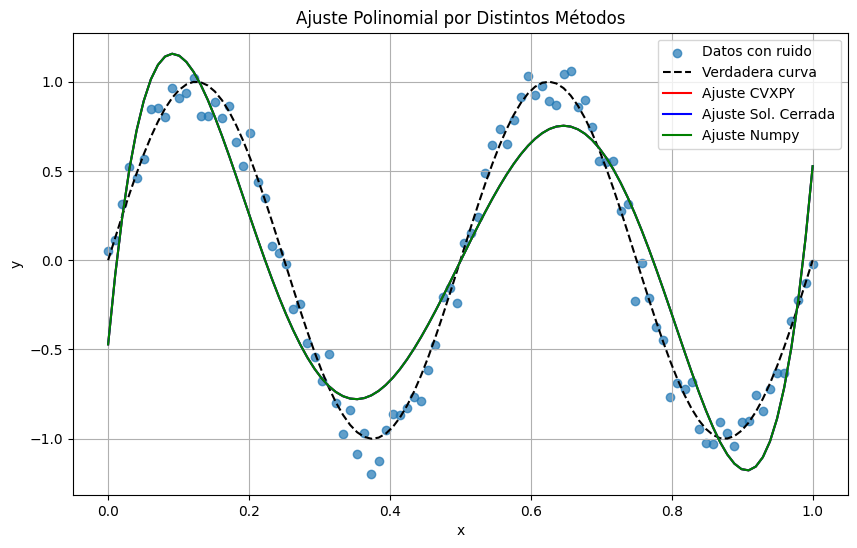

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label="Datos con ruido", alpha=0.7)
plt.plot(x, y_true, label="Verdadera curva", color="black", linestyle="--")
plt.plot(x_fit, y_fit_cvx, label="Ajuste CVXPY", color="red")
plt.plot(x_fit, y_fit_closed, label="Ajuste Sol. Cerrada", color="blue")
plt.plot(x_fit, y_fit_numpy, label="Ajuste Numpy", color="green")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Ajuste Polinomial por Distintos Métodos")
plt.grid()
plt.show()

In [ ]:
# Cálculo del error de estimación del polinomio con respecto al real
# Predicción del polinomio ajustado
y_hat = A @ coeff_cvx

# Error cuadrático medio respecto al seno real (sin ruido)
mse_real = np.mean((y_hat - y_true)**2)

print("MSE respecto a la función real:", mse_real)


MSE respecto a la función real: 0.05120316896865087


## Polynomial curve fitting con regularización

In [ ]:
lambda_reg = 0.1

# 1. Ajuste con L2-norm (Ridge Regression) usando CVXPY
#Creamos la matriz de vandermore
A2 = np.vander(x,degree + 1,increasing=True)

beta_l2 = cp.Variable(degree+1)
objective_l2 = cp.Minimize(cp.norm2(A2@beta_l2 - y)**2 + lambda_reg * cp.norm2(beta_l2)**2)
problem = cp.Problem(objective_l2)
problem.solve()

coeff_l2 = beta_l2.value

print(problem.value)
print(coeff_l2)


41.69932995740821
[ 0.51026002 -2.06105318  1.97923329  1.11611624 -0.72157393 -1.69986476]


/usr/local/lib/python3.12/dist-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [ ]:
# 2. Ajuste con L1-norm (Lasso Regression) usando CVXPY
beta_l1 = cp.Variable(degree+1)
objective_l1 = cp.Minimize(cp.norm2(A2@beta_l1 - y)**2 + lambda_reg * cp.norm1(beta_l1))
problem = cp.Problem(objective_l1)
problem.solve()

coeff_l1 = beta_l1.value

print(problem.value)
print(coeff_l1)



39.680735692267575
[ 8.63548901e-01 -5.61433880e+00  8.97392705e+00 -1.70001660e-07
 -5.28819231e+00  4.62906208e-08]


In [ ]:
# =========================
# Solución cerrada para Ridge (Closed-form)
# =========================
# A ya debe estar creada con x: A = np.vander(x, degree+1, increasing=True)
# lambda_reg ya definido

I = np.eye(A.shape[1])
# Si NO quieres penalizar el intercepto, descomenta:
# I[0, 0] = 0.0

ridge_coeff_cf = np.linalg.solve(A.T @ A + lambda_reg * I, A.T @ y)

# =========================
# Predicción con el modelo ajustado
# =========================
# x_fit debe estar definido (ej: x_fit = np.linspace(0,1,500))
A_fit = np.vander(x_fit, degree + 1, increasing=True)

y_fit_l2 = np.polyval(coeff_l2[::-1], x_fit)
y_fit_l1 = np.polyval(coeff_l1[::-1], x_fit)

# Predicción Ridge closed-form EN x_fit (no en x)
y_fit_ridge_closef = A_fit @ ridge_coeff_cf

print("x shape:", x.shape, " y_fit_ridge_closef shape:", y_fit_ridge_closef.shape)

x shape: (100,)  y_fit_ridge_closef shape: (100,)


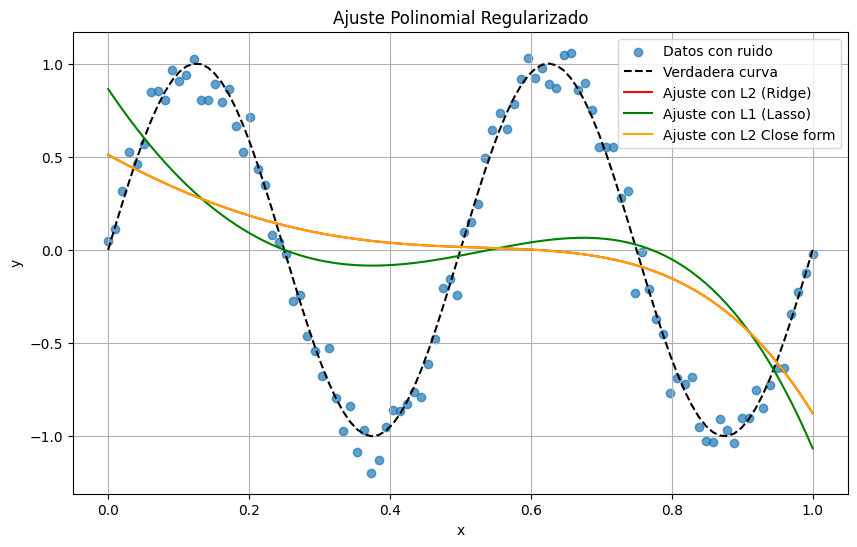

In [ ]:
#Representación de resultados

plt.figure(figsize=(10, 6))
plt.scatter(x, y, label="Datos con ruido", alpha=0.7)
plt.plot(x, y_true, label="Verdadera curva", color="black", linestyle="--")
plt.plot(x_fit, y_fit_l2, label="Ajuste con L2 (Ridge)", color="red")
plt.plot(x_fit, y_fit_l1, label="Ajuste con L1 (Lasso)", color="green")
plt.plot(x, y_fit_ridge_closef, label="Ajuste con L2 Close form", color="orange")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Ajuste Polinomial Regularizado")
plt.grid()
plt.show()

Saving Ice_cream_selling_data.csv to Ice_cream_selling_data (4).csv
   Temperature      Sales
0    -4.662263  41.842986
1    -4.316559  34.661120
2    -4.213985  39.383001
3    -3.949661  37.539845
4    -3.578554  32.284531


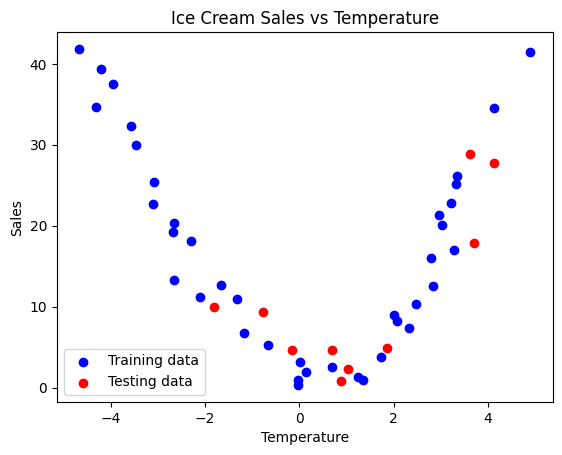

In [10]:
#PARTE 2
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

lambda_reg = 0.1
degree = 5

# CArgamos los datos
from google.colab import files
files.upload()


file_path = "Ice_cream_selling_data.csv"
data = pd.read_csv(file_path)

# visualización del dataset
print(data.head())


# Dividimos en train y test
# (Ajusta estos nombres si tus columnas se llaman distinto)
X = data["Temperature"].to_numpy().reshape(-1, 1)
y = data["Sales"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Para que plt.scatter funcione bien con X en forma (N,1)
X_train = X_train.ravel()
X_test  = X_test.ravel()


# Representamos puntos de train
plt.scatter(X_train, y_train, color='blue', label='Training data')

# Representamos puntos de test
plt.scatter(X_test, y_test, color='red', label='Testing data')

plt.xlabel('Temperature')
plt.ylabel('Sales')
plt.title('Ice Cream Sales vs Temperature')
plt.legend()

plt.show()


In [11]:
# Solución considerando regularización L1

import cvxpy as cp
import numpy as np

lambda_reg = 0.1
degree = 5

# Asegurar vector 1D
xtr = np.asarray(X_train).ravel()

# Matriz de diseño (Vandermonde)
A_train = np.vander(xtr, degree + 1, increasing=True)

# Variable y problema L1
beta_l1 = cp.Variable(degree + 1)
objective_l1 = cp.Minimize(cp.sum_squares(A_train @ beta_l1 - y_train) + lambda_reg * cp.norm1(beta_l1))
problem_l1 = cp.Problem(objective_l1)

# En Colab suele funcionar SCS
problem_l1.solve(solver=cp.SCS)

coeff_l1 = beta_l1.value

print("Objective (L1):", problem_l1.value)
print("Coefficients (L1):", coeff_l1)



Objective (L1): 224.88136259924076
Coefficients (L1): [ 1.23603964 -2.64785412  2.43048713  0.26835542 -0.02626139 -0.0073992 ]


In [12]:
# Solución considerando regularización L2
import cvxpy as cp
import numpy as np

lambda_reg = 0.1
degree = 5

# Asegurar vector 1D
xtr = np.asarray(X_train).ravel()

# Matriz de diseño (Vandermonde)
A_train = np.vander(xtr, degree + 1, increasing=True)

# Variable y problema L2
beta_l2 = cp.Variable(degree + 1)
objective_l2 = cp.Minimize(
    cp.sum_squares(A_train @ beta_l2 - y_train) +
    lambda_reg * cp.sum_squares(beta_l2)
)
problem_l2 = cp.Problem(objective_l2)

# Solver compatible con Colab
problem_l2.solve(solver=cp.SCS)

coeff_l2 = beta_l2.value

print("Objective (L2):", problem_l2.value)
print("Coefficients (L2):", coeff_l2)




Objective (L2): 225.6681502728003
Coefficients (L2): [ 1.23104466 -2.63256066  2.43114718  0.26598614 -0.02629378 -0.00732127]


In [13]:
# Evolución del error en train

# Evolución del error en train (L1 vs L2) variando lambda

import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

degree = 5

# Asegurar vector 1D
xtr = np.asarray(X_train).ravel()

# Matriz de diseño (Vandermonde) para train
A_train = np.vander(xtr, degree + 1, increasing=True)

# 17 valores: [1e-8, 1e-7, ..., 1e8]
lambdas = 10.0 ** np.arange(-8, 9)

train_mse_l1 = []
train_mse_l2 = []

for lam in lambdas:
    # ---- L2 (Ridge) ----
    w_l2 = cp.Variable(degree + 1)
    prob_l2 = cp.Problem(
        cp.Minimize(cp.sum_squares(A_train @ w_l2 - y_train) + lam * cp.sum_squares(w_l2))
    )
    prob_l2.solve(solver=cp.SCS)
    yhat_l2 = A_train @ w_l2.value
    train_mse_l2.append(np.mean((yhat_l2 - y_train) ** 2))

    # ---- L1 (Lasso) ----
    w_l1 = cp.Variable(degree + 1)
    prob_l1 = cp.Problem(
        cp.Minimize(cp.sum_squares(A_train @ w_l1 - y_train) + lam * cp.norm1(w_l1))
    )
    prob_l1.solve(solver=cp.SCS)
    yhat_l1 = A_train @ w_l1.value
    train_mse_l1.append(np.mean((yhat_l1 - y_train) ** 2))

# Plot
plt.figure(figsize=(7,4))
pl



ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [ ]:
# Evolución del error en test


